In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 08:37:28--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [    <=>             ]  19.68M  28.1MB/s    in 0.7s    

2025-06-13 08:37:29 (28.1 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
pip install Groq

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [ ]:
Groq_api_key = 'api_key'
client =Groq(api_key=Groq_api_key)

In [ ]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [ ]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""You are a python expert and you are given a dataset which is preprocessed using below code:

    df = pd.read_csv('household_power_consumption.txt',
                     sep=';',
                     parse_dates={{'datetime': ['Date', 'Time']}},
                     infer_datetime_format=True,
                     na_values=['?'],
                     low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    and following are the column names in the dataset after preprocessing where as you can see that the index is set to datetime:
    {df_info_str}


    Provide me with only python pandas code for below natural language questions no theory, explanation is needed. Please only provide the pandas code with necessary imports which should print the result when executed:
    {natural_language_question}

    """

    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [ ]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec(fixed_code, {'df': df}) #execute the code in the context of the dataframe
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [ ]:
df = load_data_set()

<ipython-input-63-2730963339>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-63-2730963339>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-63-2730963339>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [ ]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [ ]:
print(df.columns.tolist())

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [ ]:
#deepseek-r1-distill-llama-70b Model Testing

# Consider for Analysis

In [ ]:
execute_query("What was the average active power consumption in March 2007?", "deepseek-r1-distill-llama-70b", df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for March 2007 and calculate average
average_march_2007 = df.loc['2007-03-01':'2007-03-31', 'Global_active_power'].mean()
print(f"The average active power consumption in March 2007 was {average_march_2007} kW.")
------------------------------------------------------------------------
Output of the code is:

The average active power consumption in March 2007 was 1.3186270301754073 kW.


In [ ]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Load and preprocess the data (as given)
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Create a new column indicating whether the day is a weekday or weekend
df['Weekday'] = df['DayType'].apply(lambda x: 1 if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 0)
# Group by Weekday and calculate mean Global_active_power
weekday_usage = df.groupby('Weekday')['Global_active_power'].mean()
# Create a bar plot
plt.figure(figsize=(10,6))
weekday_usage.plot(kind='bar', color=['blue', 'red'])
-------------------

<string>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


Error executing code: 'DayType'


False

In [ ]:
execute_query("What was the average active power consumption in March 2007?","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for March 2007 and calculate average
average_march_2007 = df.loc['2007-03-01':'2007-03-31', 'Global_active_power'].mean()
print(f"The average active power consumption in March 2007 was {average_march_2007} kW.")
------------------------------------------------------------------------
Output of the code is:

The average active power consumption in March 2007 was 1.3186270301754073 kW.


In [ ]:
execute_query("Find days where total energy consumption exceeded 5 kWh.","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Read and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Resample data by day and calculate total energy consumption in kWh
daily_energy = df.resample('D')['Global_active_power'].sum() * (1/60)
# Find days where energy consumption exceeded 5 kWh
days_over_5 = daily_energy[daily_energy > 5]
# Print the result
print(days_over_5.index)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='datetime', length=1409, freq=None)


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Filter data for the first week of January 2007
first_week_jan_2007 = df['2007-01-01':'2007-01-07']
# Plot the energy usage trend
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
------------------------------------------------------------------------
Output of the code is:



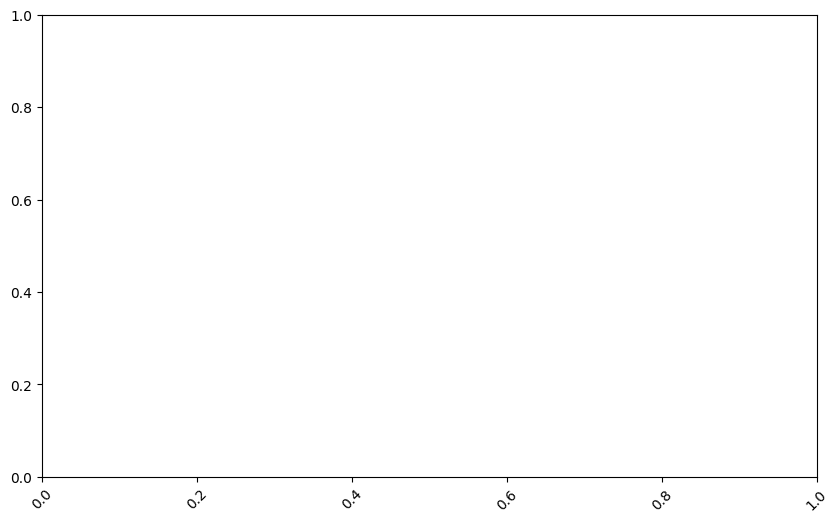

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007.","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import matplotlib.pyplot as plt
# Filter data for January 2007
jan_2007 = df[(df.index.year == 2007) & (df.index.month == 1)]
# Filter data for first week (assuming first week is first 7 days of January)
first_week = jan_2007['2007-01-01':'2007-01-07']
# Aggregate Global_active_power by day
daily_usage = first_week['Global_active_power'].resample('D').sum()
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(daily_usage.index, daily_usage.values, marker='o')
------------------------------------------------------------------------
Output of the code is:



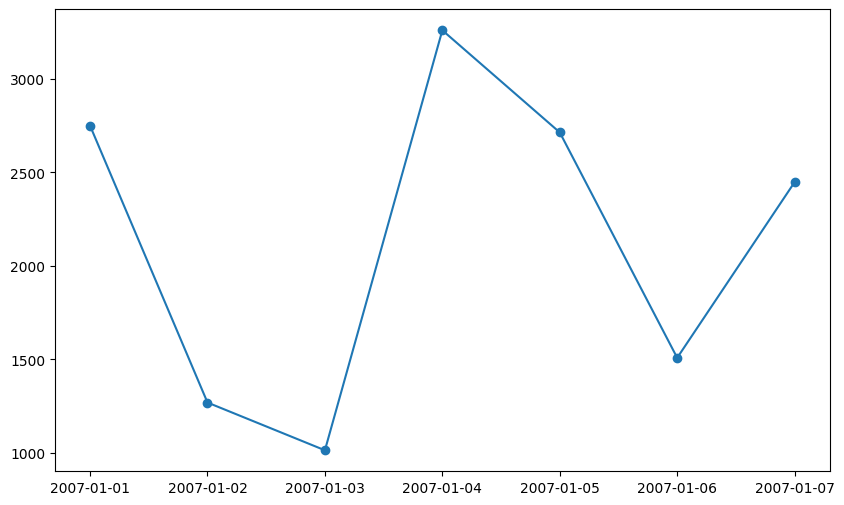

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","deepseek-r1-distill-llama-70b",df)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2007","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for February 2007
feb_2007 = df[(df.index.year == 2007) & (df.index.month == 2)]
# Filter data for the first week (1st to 7th February)
first_week_feb = feb_2007[(feb_2007.index.day >= 1) & (feb_2007.index.day <= 7)]
# Group by day and calculate average voltage
average_voltage = first_week_feb.groupby(first_week_feb.index.date)['Voltage'].mean()
# Print the result
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:

2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Name: Voltage, dtype: float64


In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?.","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Calculate correlations
correlations = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Display the correlations
print(correlations.loc['Global_active_power'])
------------------------------------------------------------------------
Output of the code is:

Global_active_power    1.000000
Sub_metering_1         0.484401
Sub_metering_2         0.434569
Sub_metering_3         0.638555
Name: Global_active_power, dtype: float64


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the preprocessed data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
# Drop rows with missing values
df = df.dropna()
# Convert Global_active_power to float
df['Global_active_power'] = df['Global_active_power'].astype(float)
# Set datetime as index
df = df.set_index('datetime')
# Calculate correlations
correlation_matrix = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)
# Create a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True

<string>:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


Correlation Matrix:
                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_metering_2             0.080872  
Sub_metering_3             1.000000  


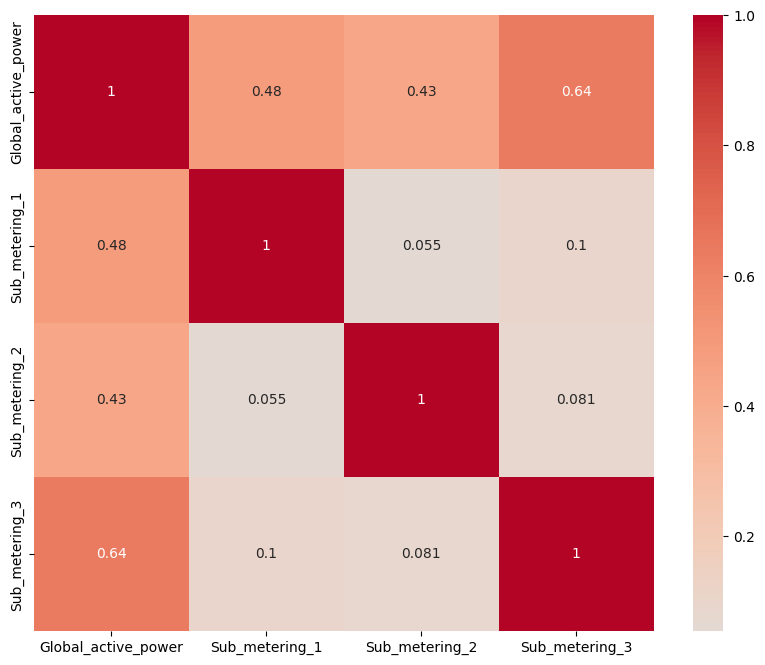

In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","deepseek-r1-distill-llama-70b",df)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Read the preprocessed data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
# Set datetime as index
df = df.set_index('datetime')
# Filter data for February 2008, first week (1st to 7th)
february_first_week = df[(df.index.year == 2008) & 
                        (df.index.month == 2) & 
                        (df.index.day <= 7)]
# Group by date and calculate average voltage
average_voltage = february_first_week.groupby(february_first_week.index.date)['Voltage'].mean()
# Print the result
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Name: Voltage, dtype: float64


In [ ]:
execute_query("Find days where energy consumption exceeded 2 kWh in 2008","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Convert Global_active_power from watts to kWh
df['Global_active_power'] = df['Global_active_power'] / 1000
# Filter data for year 2008
df_2008 = df[df.index.year == 2008]
# Group by day and calculate total consumption
daily_consumption = df_2008.groupby(df_2008.index.date)['Global_active_power'].sum()
# Find days where consumption exceeded 2 kWh
exceeded_days = daily_consumption[daily_consumption > 2]
# Print the result
print("Days in 2008 where energy consumption exceeded 2 kWh:")
print(exceeded_days)
------------------------------------------------------------------------
Output of the code is:

Days in 2008 where energy consumption exceeded 2 kWh:
2008-01-01    2.759738
2008-01-04    2.291852
2008-01-05    2.183248
2008-01-08    2.043550
2008-01-12    2.871408
                ...   
2008-12-17    2.098786
2008-12-20    2.242502
2008-12-21    2.643610
2008-12-22    2.015808
2008-12-27 

In [ ]:
execute_query("What hour of the day had the highest power usage on Christmas 2006?","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for Christmas 2006 (December 25, 2006)
christmas_2006 = df['2006-12-25']
# Group by hour and calculate total power usage
hourly_usage = christmas_2006.groupby(christmas_2006.index.hour)['Global_active_power'].sum()
# Find the hour with the highest power usage
max_usage_hour = hourly_usage.idxmax()
# Print the result
print(f"The hour with the highest power usage on Christmas 2006 was {max_usage_hour}.")
------------------------------------------------------------------------
Output of the code is:

Error executing code: '2006-12-25'


False